---
title: "Supervised Learning"
format:
  html:
    embed-resources: true
---

### Import Libraries

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load dataset
movies_reg_df = pd.read_csv("../data/processed/movies_reg.csv")

# Define targets
targets_reg = ["Revenue_Normalized", "Average_Rating"]

# define columns that are not pertinent to regression
drop_cols = ['Title', 'IMDB_ID', 'Genre', 'Directors', 'Actors', 'Producers', 'Writers',
             'Composers', 'Cinematographers', 'Production_Companies', 'num_actors']

# drop those columns
movies_reg_df = movies_reg_df.drop(columns=drop_cols)

### Regression

We will write a function to prepare data frame for regression analysis by encoding categorical variables and defining targets, scaling the features, training the model, and evaluating its performance.

In [24]:
# define a function to run regression analysis
def run_regression(df, targets):
    # Encode categorical variables as strings or one-hot later
    categorical_cols = ["Age_Rating", "Country", "Language"]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Drop target columns
    X = df.drop(columns=targets)

    results = []

    for target_col in targets:    
        # Select only rows with non-null target
        df_target = df[df[target_col].notna()].copy()

        # Define features and targets separately
        X = df_target[X.columns]
        y = df_target[target_col]

        # scale numerical features
        scaler = StandardScaler()
        numeric_cols = X.select_dtypes(include='number').columns
        dummy_cols = X.select_dtypes(exclude='number').columns
        # scale column, preserving alignment
        X_numeric_scaled = pd.DataFrame(
            scaler.fit_transform(X[numeric_cols]),
            columns=numeric_cols,
            index=X.index
        )
        # rejoin with dummy columns
        X_scaled = pd.concat([X_numeric_scaled, X[dummy_cols]], axis=1)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )

        # Initialize and train model
        lr = LinearRegression()
        lr.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = lr.predict(X_test)

        # metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results.append({
            "Target": target_col,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

        # Plot results
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.xlabel(f"True {target_col}")
        plt.ylabel(f"Predicted {target_col}")
        plt.title(f"Regression: {target_col} Prediction")
        plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
        plt.show()

    return pd.DataFrame(results)

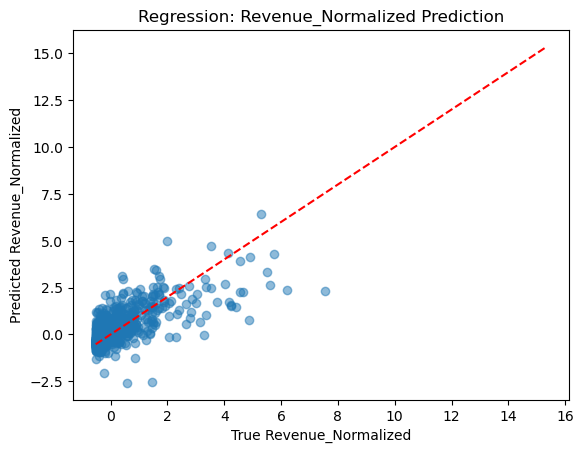

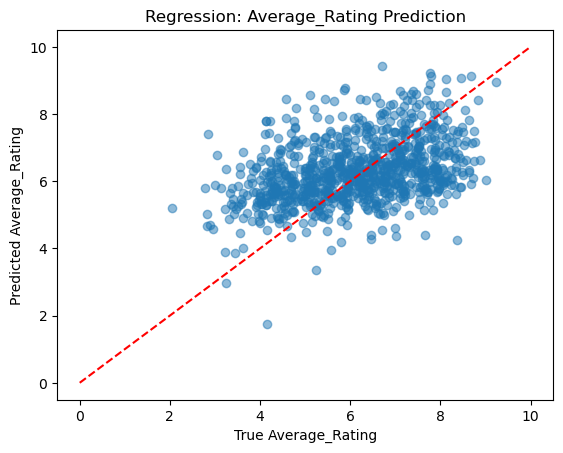

,Target,MSE,RMSE,MAE,R2
0,Revenue_Normalized,0.542132,0.736296,0.476120,0.451267
1,Average_Rating,1.807686,1.344502,1.087074,0.047602


In [25]:
# Run regression for each target
run_regression(movies_reg_df, targets_reg)

Re-run regression with Network Attributes Added

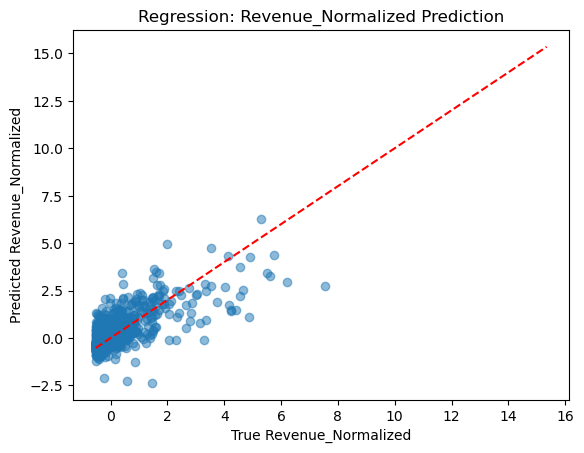

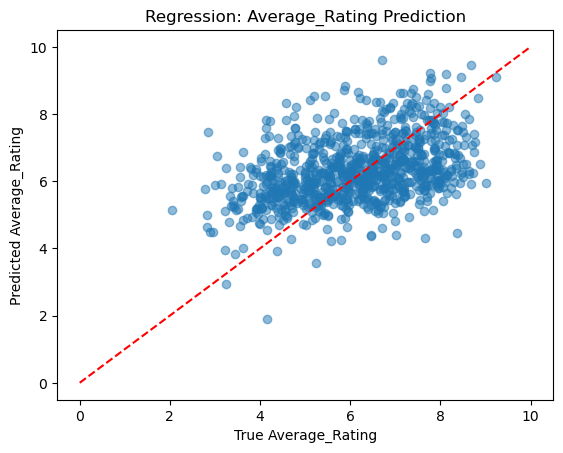

,Target,MSE,RMSE,MAE,R2
0,Revenue_Normalized,0.537066,0.732848,0.480952,0.456395
1,Average_Rating,1.787294,1.336897,1.080190,0.058346


In [26]:
# Load dataset
movies_reg_centrality_df = pd.read_csv("../data/processed/movies_reg_centrality.csv")
# drop columns from above
movies_reg_centrality_df = movies_reg_centrality_df.drop(columns=drop_cols)

# Run regression for each target
run_regression(movies_reg_centrality_df, targets_reg)

It looks like adding the centrality measures has actually decreased the performance of the model. Let's see if correlation analysis can help us understand why.

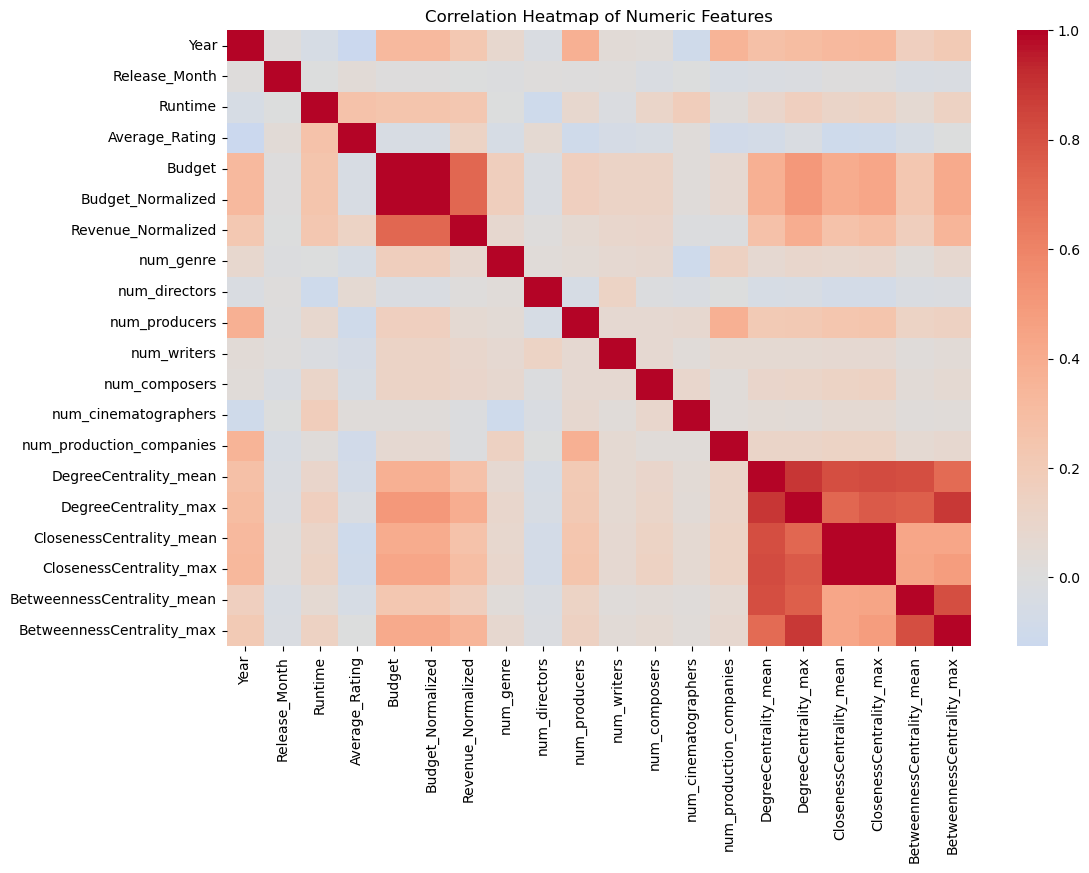

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns (including your centrality features)
numeric_cols = movies_reg_centrality_df.select_dtypes(include='number')

plt.figure(figsize=(12,8))
sns.heatmap(numeric_cols.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Only keep numeric features (after dummy encoding if already done)
X_num = movies_reg_centrality_df.select_dtypes(include='number').dropna()

# Compute VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) 
                   for i in range(len(X_num.columns))]

print(vif_data.sort_values(by="VIF", ascending=False))


                       feature           VIF
4                       Budget  94872.219638
5            Budget_Normalized  62344.470932
17     ClosenessCentrality_max    228.361404
16    ClosenessCentrality_mean    219.448588
15        DegreeCentrality_max     49.193483
14       DegreeCentrality_mean     43.794705
19   BetweennessCentrality_max     21.816666
18  BetweennessCentrality_mean     16.324279
6           Revenue_Normalized      2.270130
0                         Year      1.484228
9                num_producers      1.330770
13    num_production_companies      1.293734
2                      Runtime      1.256944
3               Average_Rating      1.193417
12        num_cinematographers      1.080563
7                    num_genre      1.078054
10                 num_writers      1.050496
11               num_composers      1.048103
8                num_directors      1.044407
1                Release_Month      1.009691


It looks like there is some multicollinearity between the centrality measures, which could be affecting the model's performance. Let's run it again only using the one of the centrality measures, which should reduce multicollinearity. From the correlation matrix, it looks like the max values are more correlated with the target than the mean values, so we will use those.

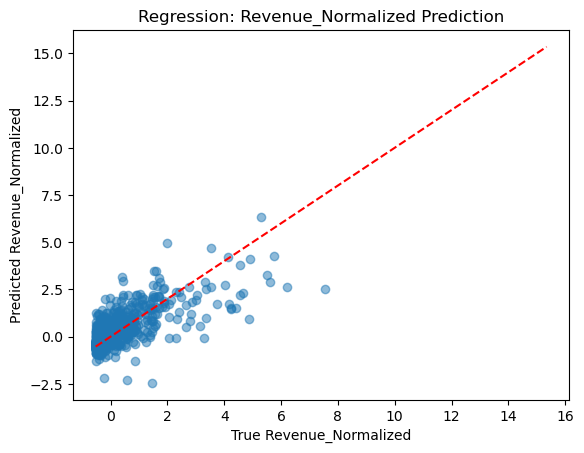

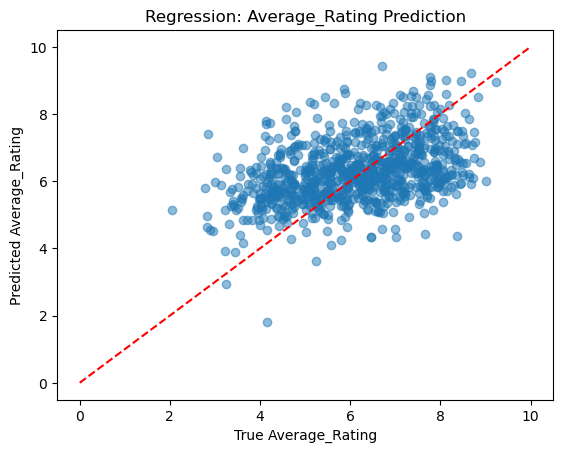

,Target,MSE,RMSE,MAE,R2
0,Revenue_Normalized,0.524862,0.724474,0.468337,0.468747
1,Average_Rating,1.757227,1.325605,1.070984,0.074187


In [29]:
# drop mean columns
movies_centrality_fewer_df = movies_reg_centrality_df.drop(columns=['DegreeCentrality_mean',	'ClosenessCentrality_mean',	'BetweennessCentrality_mean'])

# run regression
# Run regression for each target
run_regression(movies_centrality_fewer_df, targets_reg)



That improved some but not much. Let's try to see if we can create a classification model to predict the target variable instead of regression. This might help us understand the relationship better.

### Classification



In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# function to run classification
def run_classification(df, targets):
    # Encode categoricals
    categorical_cols = ["Age_Rating", "Country", "Language"]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Drop target columns
    X = df.drop(columns=targets)
    
    results = []

    for target_col in targets:
        # Select only rows with non-null target
        df_target = df[df[target_col].notna()].copy()

        # Define features and targets separately
        X = df_target[X.columns]
        y = df_target[target_col]

        # Scale numeric features
        scaler = StandardScaler()
        numeric_cols = X.select_dtypes(include='number').columns
        dummy_cols = X.select_dtypes(exclude='number').columns
        # scale column, preserving alignment
        X_numeric_scaled = pd.DataFrame(
            scaler.fit_transform(X[numeric_cols]),
            columns=numeric_cols,
            index=X.index
        )
        # rejoin with dummy columns
        X_scaled = pd.concat([X_numeric_scaled, X[dummy_cols]], axis=1)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # Fit logistic regression
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)

        # predict and evaluate
        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]

        # metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results
        results.append({
            "Target": target_col,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        })

        # Evaluation
        print(f"Classification Report for {target_col}")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.3f}")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred_prob):.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="red")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {target_col}")
        plt.legend()
        plt.show()

    return pd.DataFrame(results)

Classification Report for Success_Critical
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       673
           1       0.55      0.21      0.30       229

    accuracy                           0.76       902
   macro avg       0.66      0.58      0.58       902
weighted avg       0.72      0.76      0.71       902

Confusion Matrix:
[[634  39]
 [181  48]]
ROC-AUC: 0.714


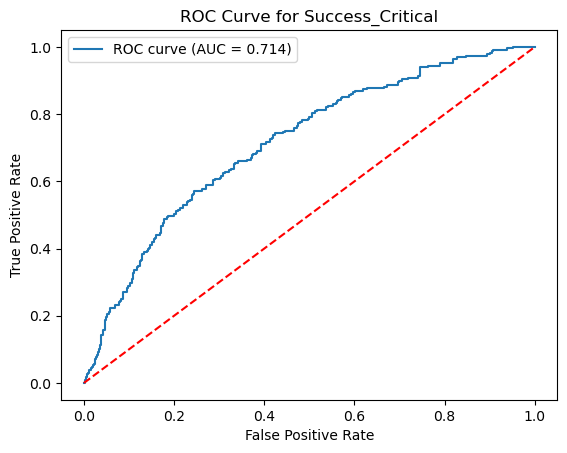

Classification Report for Success_Financial
              precision    recall  f1-score   support

           0       0.68      0.29      0.41       260
           1       0.77      0.95      0.85       642

    accuracy                           0.76       902
   macro avg       0.73      0.62      0.63       902
weighted avg       0.74      0.76      0.72       902

Confusion Matrix:
[[ 76 184]
 [ 35 607]]
ROC-AUC: 0.714


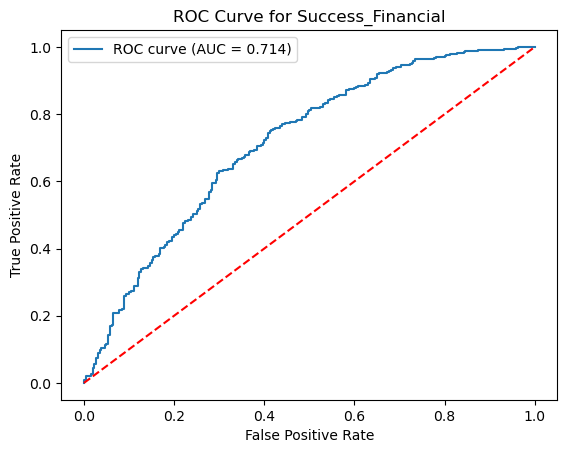

,Target,Accuracy,Precision,Recall,F1-Score
0,Success_Critical,0.756098,0.551724,0.209607,0.303797
1,Success_Financial,0.757206,0.767383,0.945483,0.847174


In [31]:
# Define targets
targets_class = ["Success_Critical", "Success_Financial"]

# Load dataset
movies_class_df = pd.read_csv("../data/processed/movies_class.csv")

# drop columns from above
movies_class_df = movies_class_df.drop(columns=drop_cols)

# Run classification for each target
run_classification(movies_class_df, targets_class)

Classification Report for Success_Critical
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       673
           1       0.54      0.20      0.29       229

    accuracy                           0.75       902
   macro avg       0.66      0.57      0.57       902
weighted avg       0.72      0.75      0.71       902

Confusion Matrix:
[[634  39]
 [183  46]]
ROC-AUC: 0.721


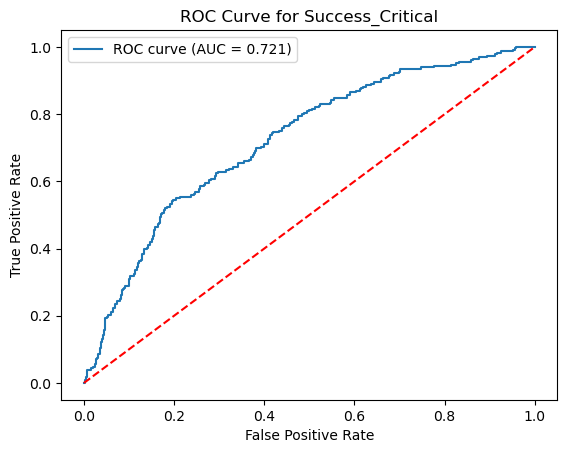

Classification Report for Success_Financial
              precision    recall  f1-score   support

           0       0.67      0.30      0.41       260
           1       0.77      0.94      0.85       642

    accuracy                           0.75       902
   macro avg       0.72      0.62      0.63       902
weighted avg       0.74      0.75      0.72       902

Confusion Matrix:
[[ 78 182]
 [ 39 603]]
ROC-AUC: 0.707


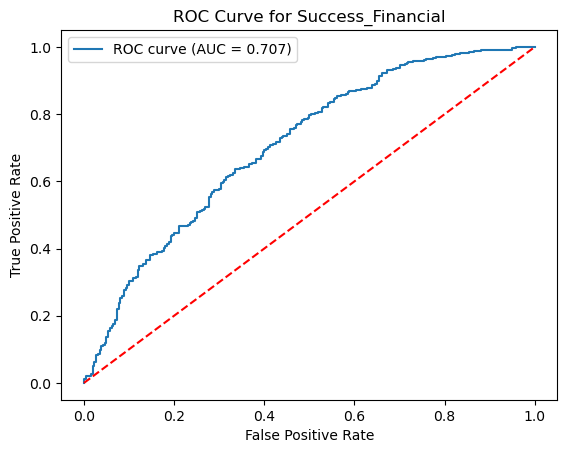

,Target,Accuracy,Precision,Recall,F1-Score
0,Success_Critical,0.753880,0.541176,0.200873,0.292994
1,Success_Financial,0.754989,0.768153,0.939252,0.845130


In [32]:
# Load dataset
movies_class_centrality_df = pd.read_csv("../data/processed/movies_class_centrality.csv")

# drop columns from above
movies_class_centrality_df = movies_class_centrality_df.drop(columns=drop_cols)

# Run classification for each target
run_classification(movies_class_centrality_df, targets_class)